In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import utils
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from RandomForest import RandomForestClassifierImpl

from mlxtend.evaluate import bias_variance_decomp

## Генерация выборки

In [2]:
max = 7
precision = .1

def create_grid():
  return np.mgrid[-max:max:precision, -max:max:precision]

In [3]:
_dist1_comp_1 = multivariate_normal([-2,2], [[7, 0], [-1, 2]])
_dist1_comp_2 = multivariate_normal([2,1], [[4, 1], [1, 2]])

def prob_1(pos):
  return _dist1_comp_1.pdf(pos) + _dist1_comp_2.pdf(pos)

In [4]:
_dist2_comp_1 = multivariate_normal([3,0], [[2, 1], [1, 2]])
_dist2_comp_2 = multivariate_normal([0,-2], [[4, 1], [1, 2]])
_dist2_comp_3 = multivariate_normal([-1,-1], [[4, 1], [1, 2]])

def prob_2(pos):
  return _dist2_comp_1.pdf(pos) + _dist2_comp_2.pdf(pos) + _dist2_comp_3.pdf(pos)

In [5]:
x, y = create_grid()
pos = np.dstack((x, y))

In [6]:
maxProb1 = np.max(prob_1(pos))
maxProb2 = np.max(prob_2(pos))

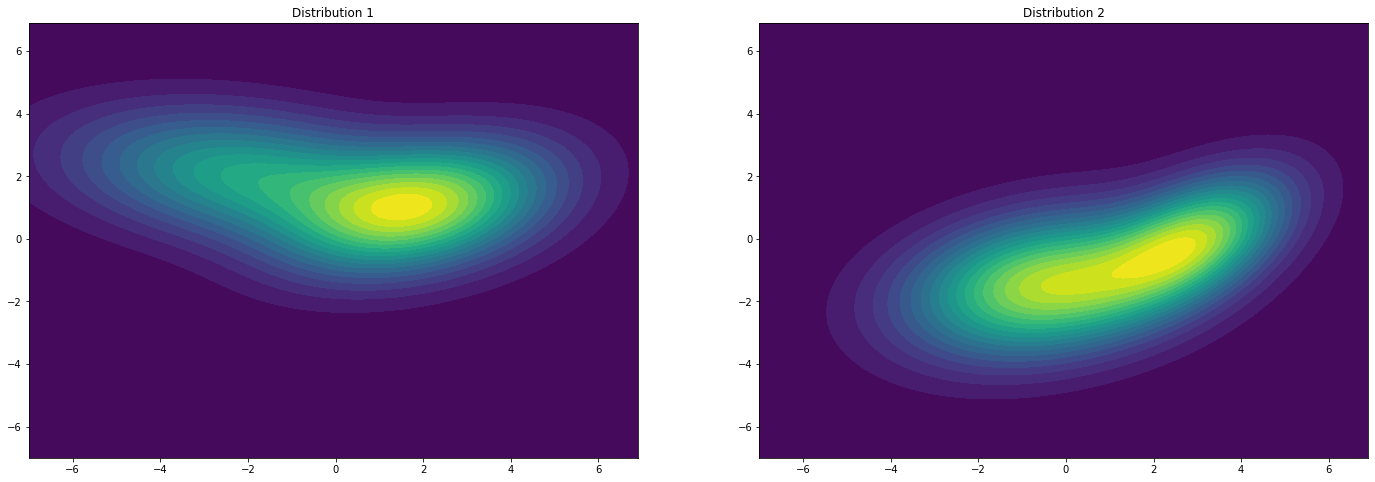

In [7]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Distribution 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)

ax2 = fig.add_subplot(122)
ax2.set_title('Distribution 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)

plt.show()

In [8]:
def generate_samples(prob, max_prob, size, target):
  samples = []
  while len(samples) != size:
    randCoords = np.random.uniform(-max, max, 2)
    randProb = np.random.uniform(0.0, 1.0, 1)[0]
    sample_prob = prob([randCoords[0], randCoords[1]])
    if (sample_prob / max_prob > randProb):
      samples.append([target, randCoords[0], randCoords[1]])
  return np.array(samples)

def generate_dataset(size, verbose = False):
  size1 = round(np.random.normal(size / 2, 7, 1)[0])
  if size1 <= 0 or size1 > size:
    size1 = round(size / 2)

  samples1 = generate_samples(prob_1, maxProb1, size1, 0)
  samples2 = generate_samples(prob_2, maxProb2, size - size1, 1)

  if verbose:
    print(f"Created samples: {size}")
    print(f"Samples ratio: {size1}/{size - size1}")

  dataset = np.concatenate([samples1, samples2])
  return utils.shuffle(dataset)

In [9]:
dataset = generate_dataset(100, verbose=True)

Created samples: 100
Samples ratio: 56/44


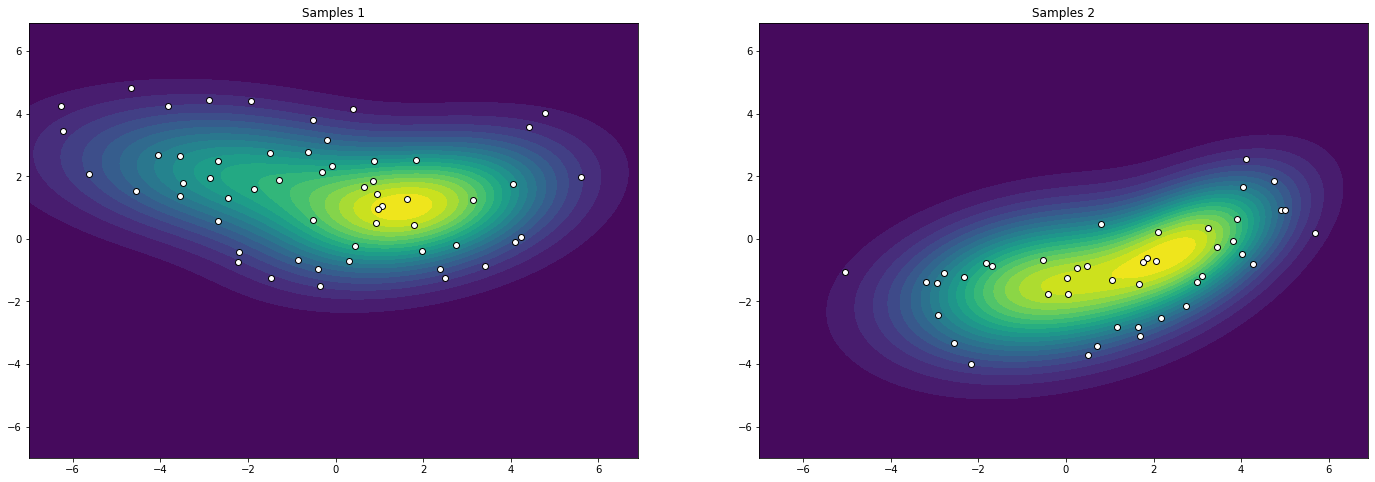

In [10]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Samples 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)
ax.scatter(dataset[dataset[:, 0] == 0, 1], dataset[dataset[:, 0] == 0, 2], c='white', edgecolors='black')

ax2 = fig.add_subplot(122)
ax2.set_title('Samples 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)
ax2.scatter(dataset[dataset[:, 0] == 1, 1], dataset[dataset[:, 0] == 1, 2], c='white', edgecolors='black')

plt.show()

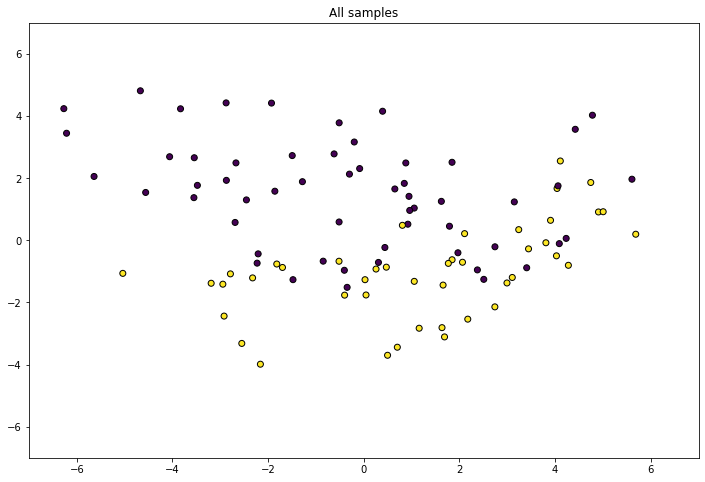

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_title('All samples')
ax.set_xlim(-max, max)
ax.set_ylim(-max, max)
ax.scatter(dataset[:,1],dataset[:,2], c=dataset[:,0], edgecolors='black');

## Random forest

In [12]:
def draw_predictions_on_decision_plane(clf, ax, dataset, decision_grid):
    ax.set_xlim(-max, max)
    ax.set_ylim(-max, max)
    cs = ax.contourf(x, y, decision_grid , levels=1)
    ax.scatter(dataset[:,1],dataset[:,2], c=dataset[:,0], edgecolors='black');
    predictions = clf.predict(dataset[:, 1:])
    ax.scatter(dataset[dataset[:, 0] != predictions, 1], 
            dataset[dataset[:, 0] != predictions, 2], c='red', marker='x')


def decision_plane_test(clf, train_dataset, test_dataset):
    clf.fit(train_dataset[:, 1:], train_dataset[:, 0])
    decision_grid = clf.predict(pos.reshape(pos.shape[0]**2, 2))
    decision_grid = decision_grid.reshape(pos.shape[0],pos.shape[1])

    fig = plt.figure(figsize=(24, 8))

    train_sub_plot = fig.add_subplot(121)
    train_sub_plot.set_title(f'Prediction result on the decision plane | Train score: {clf.score(train_dataset[:, 1:], train_dataset[:, 0])}')
    draw_predictions_on_decision_plane(clf, train_sub_plot, train_dataset, decision_grid)
    
    test_sub_plot = fig.add_subplot(122)
    test_sub_plot.set_title(f'Prediction result on the decision plane | Test score: {clf.score(test_dataset[:, 1:], test_dataset[:, 0])}')
    draw_predictions_on_decision_plane(clf, test_sub_plot, test_dataset, decision_grid)

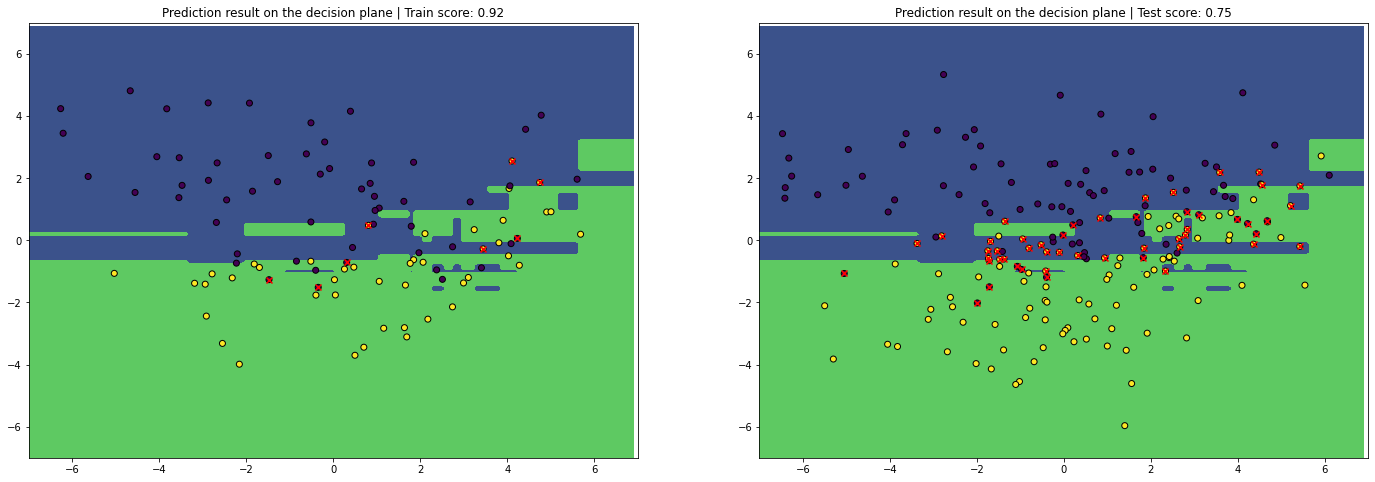

In [13]:
test_dataset = generate_dataset(200)
clf = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=0)
decision_plane_test(clf, dataset, test_dataset)

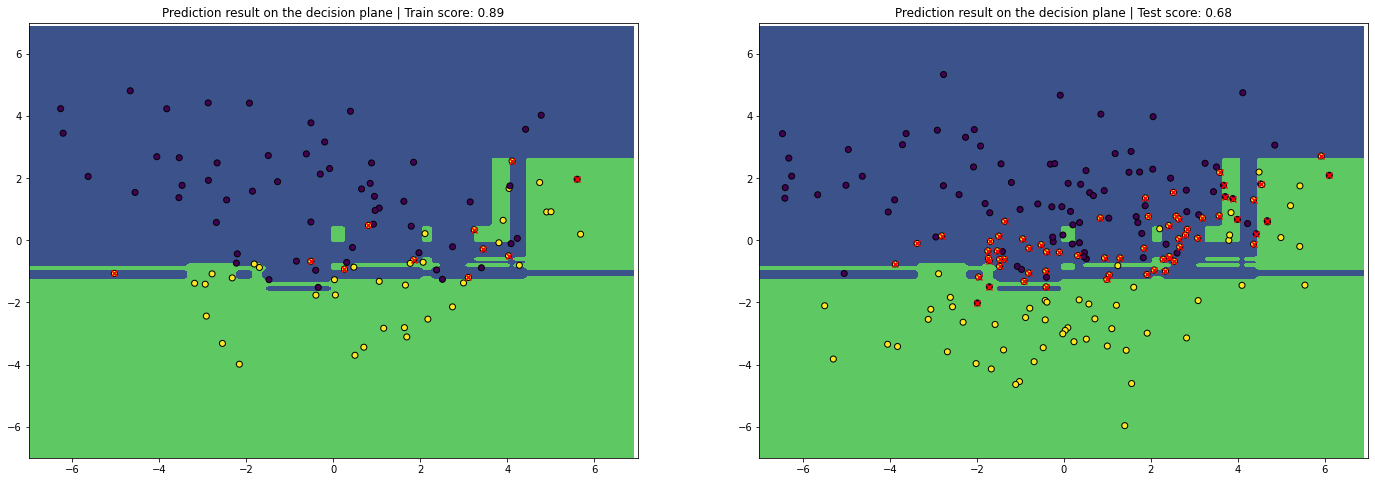

In [14]:
clf = RandomForestClassifierImpl(n_estimators=5, max_depth=5, random_state=0)
decision_plane_test(clf, dataset, test_dataset)

## Teст моделей

In [15]:
def score_test(clf, repeats, model_name):
  results = []
  for i in range(repeats):
    print(f'{model_name} {i+1}/{repeats}')
    result = []

    train_dataset = generate_dataset(100)
    X = train_dataset[:, 1:]
    y = train_dataset[:, 0]

    clf.fit(X, y)
    result.append(1 - clf.score(X, y))
    
    scores_cv = []
    kFolds = KFold(n_splits=5, shuffle=False)
    for train_index, test_index in kFolds.split(y):
      X_train = np.take(X, train_index, axis=0)
      X_test = np.take(X, test_index, axis=0)
      y_train = np.take(y, train_index)
      y_test = np.take(y, test_index)
      clf.fit(X_train, y_train)
      scores_cv.append(1 - clf.score(X_test, y_test))
    result.append(np.mean(scores_cv))

    clf.fit(X, y)
    test_dataset = generate_dataset(10000)
    X = test_dataset[:, 1:]
    y = test_dataset[:, 0]
    result.append(1 - clf.score(X, y))

    results.append(result)
  
  df = pd.DataFrame(results)
  df.columns = ['Эмпирический риск','Скользящий экзамен','Контрольная выборка']

  return df

In [16]:
empiric = pd.DataFrame()
cross_val = pd.DataFrame()
control = pd.DataFrame()

empiric_mean = pd.DataFrame()
cross_val_mean = pd.DataFrame()
control_mean = pd.DataFrame()

empiric_std = pd.DataFrame()
cross_val_std = pd.DataFrame()
control_std = pd.DataFrame()

def model_test(model):
    results = score_test(model[1], 50, model[0])

    empiric[model[0]] = results.iloc[:, 0]
    cross_val[model[0]] = results.iloc[:, 1]
    control[model[0]] = results.iloc[:, 2]

    mean = results.mean()
    std = results.std()

    empiric_mean[model[0]] = [mean[0]]
    cross_val_mean[model[0]] = [mean[1]]
    control_mean[model[0]] = [mean[2]]
    
    empiric_std[model[0]] = [std[0]]
    cross_val_std[model[0]] = [std[1]]
    control_std[model[0]] = [std[2]]


In [17]:
models = np.array([["RandomForest", RandomForestClassifier(n_estimators=20, max_depth=25)],
                   ["RandomForestImpl", RandomForestClassifierImpl(n_estimators=10, max_depth=10)],
                   ["GradientBoosting", GradientBoostingClassifier(n_estimators=10, max_depth=5)],
                   ["AdaBoosting", AdaBoostClassifier(n_estimators=10)]])
for model in models:
    model_test(model)

RandomForest 1/5
RandomForest 2/5
RandomForest 3/5
RandomForest 4/5
RandomForest 5/5
RandomForestImpl 1/5
RandomForestImpl 2/5
RandomForestImpl 3/5
RandomForestImpl 4/5
RandomForestImpl 5/5
GradientBoosting 1/5
GradientBoosting 2/5
GradientBoosting 3/5
GradientBoosting 4/5
GradientBoosting 5/5
AdaBoosting 1/5
AdaBoosting 2/5
AdaBoosting 3/5
AdaBoosting 4/5
AdaBoosting 5/5


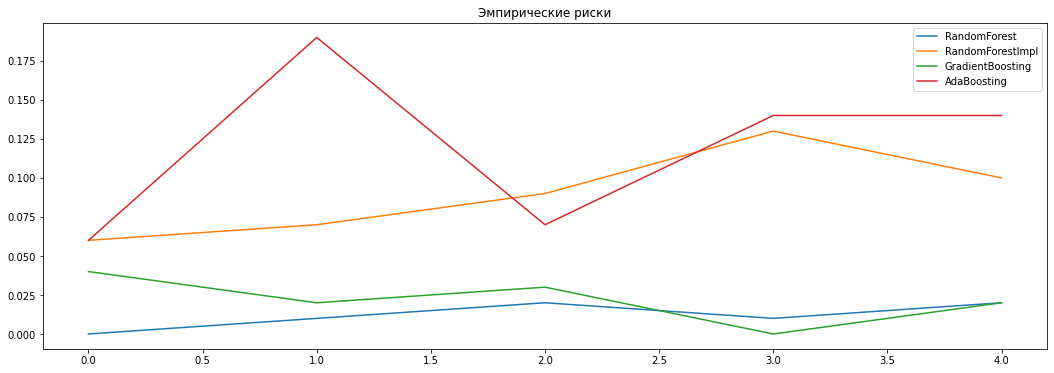

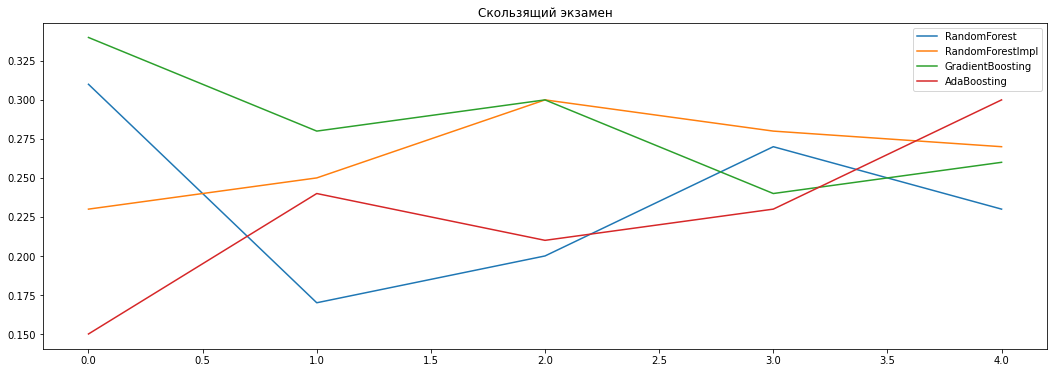

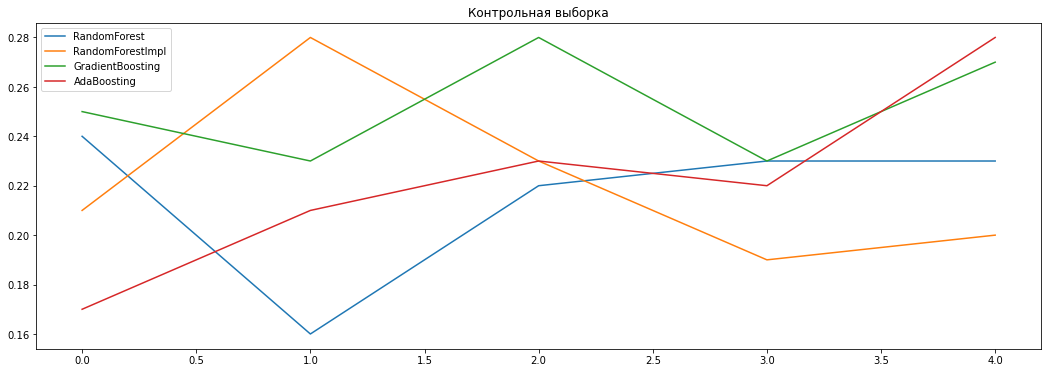

In [18]:
empiric.plot(figsize=(18,6), title="Эмпирические риски")
cross_val.plot(figsize=(18,6), title="Скользящий экзамен")
control.plot(figsize=(18,6), title="Контрольная выборка");

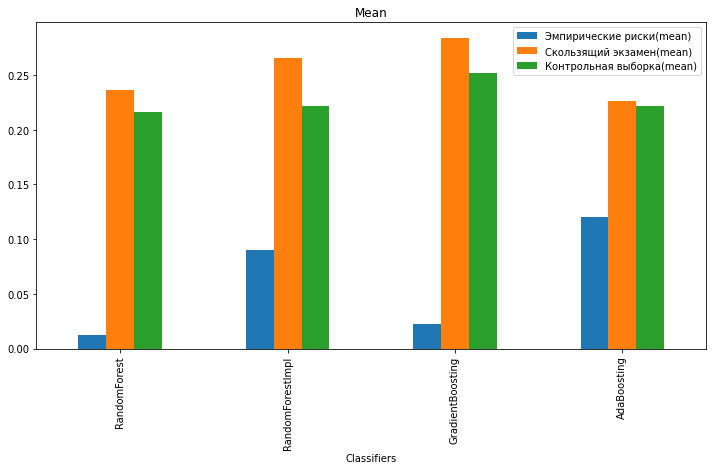

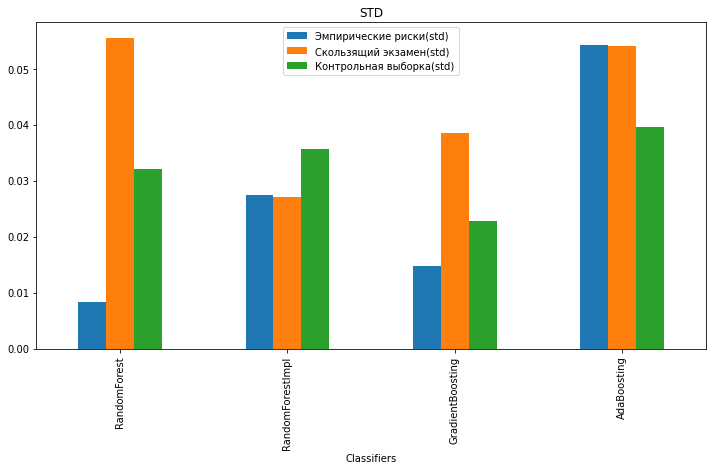

In [19]:
means = pd.DataFrame()
means['Classifiers'] = models[:, 0]
means['Эмпирические риски(mean)'] = empiric_mean.values[0]
means['Скользящий экзамен(mean)'] = cross_val_mean.values[0]
means['Контрольная выборка(mean)'] = control_mean.values[0]
means.plot('Classifiers', kind = 'bar', figsize=(12,6), title='Mean');

stds = pd.DataFrame()
stds['Classifiers'] = models[:, 0]
stds['Эмпирические риски(std)'] = empiric_std.values[0]
stds['Скользящий экзамен(std)'] = cross_val_std.values[0]
stds['Контрольная выборка(std)'] = control_std.values[0]
stds.plot('Classifiers', kind = 'bar', figsize=(12,6), title='STD');

## Разброс и смещение

In [20]:
train = generate_dataset(2000)
test = generate_dataset(400)

X_train = train[:, 1:]
y_train = train[:, 0]

X_test = test[:, 1:]
y_test = test[:, 0]

models = np.array([["RandomForest", RandomForestClassifier()],
                   ["RandomForestImpl", RandomForestClassifierImpl()],
                   ["GradientBoosting", GradientBoostingClassifier()],
                   ["AdaBoosting", AdaBoostClassifier()]])

def test_var_bias(model):
    _, bias, variance = bias_variance_decomp(model, X_train, y_train, X_train, y_train, loss='mse')
    return bias, variance

In [21]:
biases_variances = pd.DataFrame()
biases_variances['Classifiers'] = models[:, 0]

biases = []
variances = []

for model in models:
    print(model[0])
    bias, var = test_var_bias(model[1])
    biases.append(bias)
    variances.append(var)

biases_variances['Bias'] = biases
biases_variances['Variance'] = variances

RandomForest
RandomForestImpl
GradientBoosting
AdaBoosting


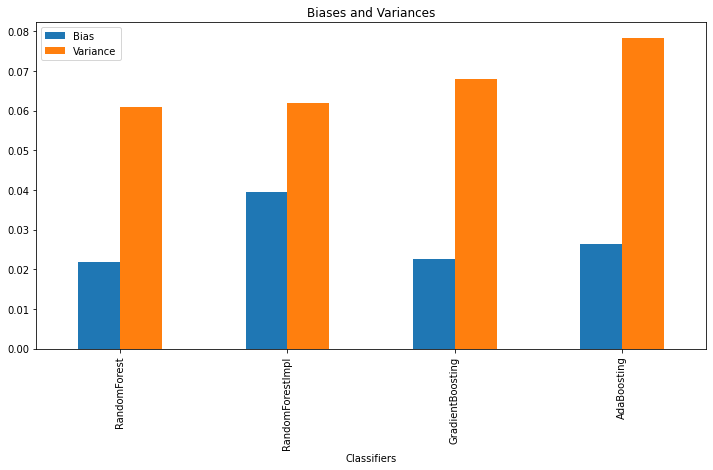

In [22]:
biases_variances.plot('Classifiers', kind = 'bar', figsize=(12,6), title='Biases and Variances');

In [23]:
n_estims = [5, 7, 9, 15, 20, 30]
max_depth = [5, 10, 15, 20, 25]

biases_frame = pd.DataFrame()
biases_frame['max_depth'] = max_depth
var_frame = pd.DataFrame()
var_frame['max_depth'] = max_depth

for n_est in n_estims:
    biases = []
    variances = []
    for max_dep in max_depth:
        print(f'n={n_est} d={max_dep}')
        clf = RandomForestClassifier(n_estimators=n_est, max_depth=max_dep)
        bias, var = test_var_bias(clf)

        biases.append(bias)
        variances.append(var)

    biases_frame[f'n_estimators={n_est}'] = biases
    var_frame[f'n_estimators={n_est}'] = variances

n=5 d=5
n=5 d=10
n=5 d=15
n=5 d=20
n=5 d=25
n=7 d=5
n=7 d=10
n=7 d=15


KeyboardInterrupt: 

<AxesSubplot:title={'center':'Variances'}, xlabel='max_depth'>

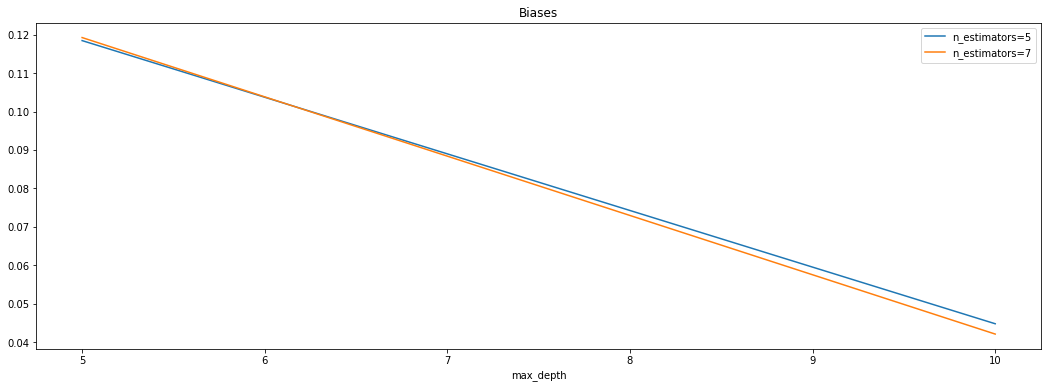

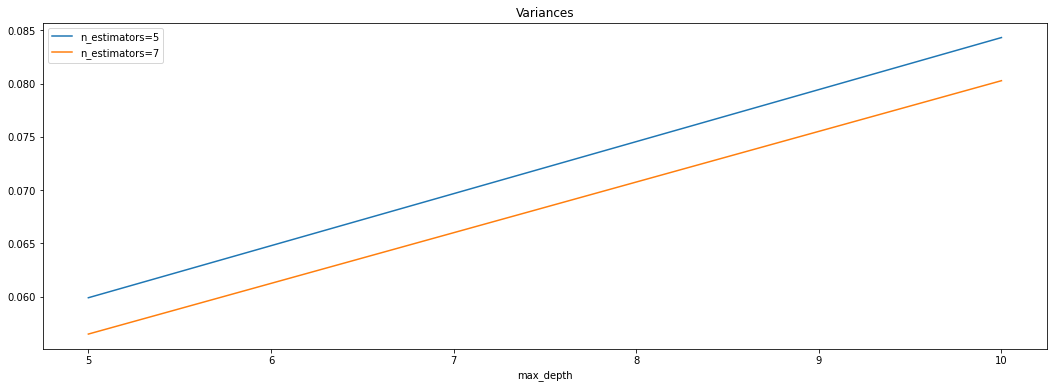

In [ ]:
biases_frame.plot(figsize=(18,6), title="Biases", x='max_depth')
var_frame.plot(figsize=(18,6), title="Variances", x='max_depth')